In [2]:
!pip install fastai
!pip install graphviz
!pip install pandas_summary
!pip install -U sagemaker


     |████████████████████████████████| 187 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 13.9 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 19.1 MB/s  eta 0:00:01
     |████████████████████████████████| 127.9 MB 53.4 MB/s eta 0:00:01
     |████████████████████████████████| 12.5 MB 30.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 101.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 33.8 MB/s eta 0:00:01
     |████████████████████████████████| 450 kB 107.4 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 6.8 MB/s  eta 0:00:01
     |████████████████████████████████| 597 kB 91.1 MB/s eta 0:00:01
     |████████████████████████████████| 105 kB 125.6 MB/s eta 0:00:01
     |████████████████████████████████| 113 kB 128.1 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107097 sha256=9396d18006e0236aecc8744805b8ffce0221001d7b77869e363106287b570f64
  Store

     |████████████████████████████████| 415 kB 2.4 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.46.1-py2.py3-none-any.whl size=583524 sha256=dc07938de1e1fe8d2d87748a21fd1c274a1d7fa5d27e973425fa598cb459a4cc
  Stored in directory: /Users/shepsheppard/Library/Caches/pip/wheels/b3/93/ed/a0c3f3efcf2756f652efd31df623d9db231253ac93edaccf4c
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.46.0
    Uninstalling sagemaker-2.46.0:
      Successfully uninstalled sagemaker-2.46.0


In [4]:
%matplotlib inline

from sklearn.model_selection import train_test_split
import fastai
import math
import boto3

import pandas  as pd 
import numpy  as np 
#from graphviz import Digraph
from pandas_summary import DataFrameSummary
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

import sagemaker
from sagemaker import get_execution_role
sess = sagemaker.Session()
#role = get_execution_role()
role = "arn:aws:iam::759916367757:role/service-role/AmazonSageMaker-ExecutionRole-20210219T114537"
print(role[role.rfind('/') + 1:])

AmazonSageMaker-ExecutionRole-20210219T114537


In [5]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1



In [6]:
epa = pd.read_csv('https://raw.githubusercontent.com/sqlshep/SQLShepBlog/master/data/epaMpg.csv')

In [7]:
epa

RowNumber Represented.Test.Veh.Make             Model Vehicle.Type  \
0             1              Aston Martin          Rapide S          Car   
1             2              Aston Martin          Vanquish          Car   
2             3                   BENTLEY    Continental GT          Car   
3             4                   BENTLEY    Continental GT          Car   
4             5                       BMW  230i Convertible          Car   
...         ...                       ...               ...          ...   
1029       1036                     Volvo       XC60 T8 AWD         Both   
1030       1037                     Volvo       XC90 T5 AWD         Both   
1031       1038                     Volvo       XC90 T5 FWD         Both   
1032       1039                     Volvo       XC90 T6 AWD         Both   
1033       1040                     Volvo       XC90 T8 AWD         Both   

      HorsePower  Cylinders Tested.Transmission.Type.Code  \
0            552         12                            SA   
1            568         12                            SA   
2            616         12                            SA   
3            616         12                            SA   
4            248          4                            SA   
...          ...        ...                           ...   
1029         313          4                            SA   
1030         250          4                            SA   
1031         250          4                            SA   
1032         316          4                            SA   
1033         313          4                            SA   

     Tested.Transmission.Type  Gears Drive.System.Code  Weight  AxleRatio  \
0              Semi-Automatic      8                 R    4750       2.73   
1              Semi-Automatic      8                 R    4500       2.73   
2              Semi-Automatic      8                 F    6000       2.85   
3              Semi-Automatic      8                 F    6000       2.85   
4              Semi-Automatic      8                 R    4000       2.81   
...                       ...    ...               ...     ...        ...   
1029           Semi-Automatic      8                 A    5000       3.33   
1030           Semi-Automatic      8                 F    5000       3.33   
1031           Semi-Automatic      8                 F    4750       3.33   
1032           Semi-Automatic      8                 F    5000       3.33   
1033           Semi-Automatic      8                 A    5500       3.33   

      Test.Procedure.Cd               Test.Procedure.Description  \
0                    21  Federal fuel 2-day exhaust (w/can load)   
1                    21  Federal fuel 2-day exhaust (w/can load)   
2                    90                                     US06   
3                    11                                  Cold CO   
4                     3                                     HWFE   
...                 ...                                      ...   
1029                 21  Federal fuel 2-day exhaust (w/can load)   
1030                 31               Federal fuel 3-day exhaust   
1031                 31               Federal fuel 3-day exhaust   
1032                  3                                     HWFE   
1033                 21  Federal fuel 2-day exhaust (w/can load)   

      Test.Fuel.Type.Cd Test.Fuel.Type.Description  FuelEcon  
0                    61       Tier 2 Cert Gasoline      17.3  
1                    61       Tier 2 Cert Gasoline      16.5  
2                    61       Tier 2 Cert Gasoline      17.4  
3                    27   Cold CO Premium (Tier 2)      13.6  
4                    61       Tier 2 Cert Gasoline      45.8  
...                 ...                        ...       ...  
1029                 61       Tier 2 Cert Gasoline      33.1  
1030                 61       Tier 2 Cert Gasoline      27.4  
1031                 61       Tier 2 Cert Gasoline 

In [8]:
epa.shape

(1034, 17)

In [9]:
epa.describe(include='all').T

count unique  \
RowNumber                      1034.0    NaN   
Represented.Test.Veh.Make        1034     45   
Model                            1034    541   
Vehicle.Type                     1034      3   
HorsePower                     1034.0    NaN   
Cylinders                      1034.0    NaN   
Tested.Transmission.Type.Code    1034      7   
Tested.Transmission.Type         1034      7   
Gears                          1034.0    NaN   
Drive.System.Code                1034      5   
Weight                         1034.0    NaN   
AxleRatio                      1034.0    NaN   
Test.Procedure.Cd              1034.0    NaN   
Test.Procedure.Description       1034      8   
Test.Fuel.Type.Cd              1034.0    NaN   
Test.Fuel.Type.Description       1034      6   
FuelEcon                       1034.0    NaN   

                                                                   top freq  \
RowNumber                                                          NaN  NaN   
Represented.Test.Veh.Make                                          BMW   85   
Model                                                           CAMARO   14   
Vehicle.Type                                                       Car  664   
HorsePower                                                         NaN  NaN   
Cylinders                                                          NaN  NaN   
Tested.Transmission.Type.Code                                       SA  399   
Tested.Transmission.Type                                Semi-Automatic  399   
Gears                                                              NaN  NaN   
Drive.System.Code                                                    F  468   
Weight                                                             NaN  NaN   
AxleRatio                                                          NaN  NaN   
Test.Procedure.Cd                                                  NaN  NaN   
Test.Procedure.Description     Federal fuel 2-day exhaust (w/can load)  488   
Test.Fuel.Type.Cd                                                  NaN  NaN   
Test.Fuel.Type.Description                        Tier 2 Cert Gasoline  888   
FuelEcon                                                           NaN  NaN   

                                      mean         std     min     25%  \
RowNumber                       521.361702  300.241933     1.0  262.25   
Represented.Test.Veh.Make              NaN         NaN     NaN     NaN   
Model                                  NaN         NaN     NaN     NaN   
Vehicle.Type                           NaN         NaN     NaN     NaN   
HorsePower                      291.824952  144.294932    72.0   181.0   
Cylinders                         5.431335    1.905214     3.0     4.0   
Tested.Transmission.Type.Code          NaN         NaN     NaN     NaN   
Tested.Transmission.Type               NaN         NaN     NaN     NaN   
Gears                             6.509671    1.992824     1.0     6.0   
Drive.System.Code                      NaN         NaN     NaN     NaN   
Weight                         4191.852031  787.821434  2375.0  3625.0   
AxleRatio                         3.411064    0.586484    1.56    3.07   
Test.Procedure.Cd                 24.99323   22.078601     2.0    11.0   
Test.Procedure.Description             NaN         NaN     NaN     NaN   
Test.Fuel.Type.Cd                56.366538    11.63365    19.0    61.0   
Test.Fuel.Type.Description             NaN         NaN     NaN     NaN   
FuelEcon                         28.216538    9.496233     9.2  21.525   

                                  50%     75%     max  
RowNumber                       520.5  781.75  1040.0  
Represented.Test.Veh.Make         NaN     NaN     NaN  
Model                             NaN     NaN     NaN  
Vehicle.Type                      NaN     NaN     NaN  
HorsePower                      271.5   355.0  1500.0  
Cylinders                         4.0     6.0    16.0  
Tested.Transmission

In [10]:
epa = epa.drop(epa.columns[[0]], axis=1)

epa.columns = epa.columns.str.replace('.', '_')

<ipython-input-10-eab45b2a7264>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  epa.columns = epa.columns.str.replace('.', '_')


In [11]:
epa

Represented_Test_Veh_Make             Model Vehicle_Type  HorsePower  \
0                 Aston Martin          Rapide S          Car         552   
1                 Aston Martin          Vanquish          Car         568   
2                      BENTLEY    Continental GT          Car         616   
3                      BENTLEY    Continental GT          Car         616   
4                          BMW  230i Convertible          Car         248   
...                        ...               ...          ...         ...   
1029                     Volvo       XC60 T8 AWD         Both         313   
1030                     Volvo       XC90 T5 AWD         Both         250   
1031                     Volvo       XC90 T5 FWD         Both         250   
1032                     Volvo       XC90 T6 AWD         Both         316   
1033                     Volvo       XC90 T8 AWD         Both         313   

      Cylinders Tested_Transmission_Type_Code Tested_Transmission_Type  Gears  \
0            12                            SA           Semi-Automatic      8   
1            12                            SA           Semi-Automatic      8   
2            12                            SA           Semi-Automatic      8   
3            12                            SA           Semi-Automatic      8   
4             4                            SA           Semi-Automatic      8   
...         ...                           ...                      ...    ...   
1029          4                            SA           Semi-Automatic      8   
1030          4                            SA           Semi-Automatic      8   
1031          4                            SA           Semi-Automatic      8   
1032          4                            SA           Semi-Automatic      8   
1033          4                            SA           Semi-Automatic      8   

     Drive_System_Code  Weight  AxleRatio  Test_Procedure_Cd  \
0                    R    4750       2.73                 21   
1                    R    4500       2.73                 21   
2                    F    6000       2.85                 90   
3                    F    6000       2.85                 11   
4                    R    4000       2.81                  3   
...                ...     ...        ...                ...   
1029                 A    5000       3.33                 21   
1030                 F    5000       3.33                 31   
1031                 F    4750       3.33                 31   
1032                 F    5000       3.33                  3   
1033                 A    5500       3.33                 21   

                   Test_Procedure_Description  Test_Fuel_Type_Cd  \
0     Federal fuel 2-day exhaust (w/can load)                 61   
1     Federal fuel 2-day exhaust (w/can load)                 61   
2                                        US06                 61   
3                                     Cold CO                 27   
4                                        HWFE                 61   
...                                       ...                ...   
1029  Federal fuel 2-day exhaust (w/can load)                 61   
1030               Federal fuel 3-day exhaust                 61   
1031               Federal fuel 3-day exhaust                 61   
1032                                     HWFE                 61   
1033  Federal fuel 2-day exhaust (w/can load)                 61   

     Test_Fuel_Type_Description  FuelEcon  
0          Tier 2 Cert Gasoline      17.3  
1          Tier 2 Cert Gasoline      16.5  
2          Tier 2 Cert Gasoline      17.4  
3      Cold CO Premium (Tier 2)      13.6  
4          Tier 2 Cert Gasoline      45.8  
...                         ...       ...  
1029       Tier 2 Cert Gasoline      33.1  
1030       Tier 2 Cert Gasoline      27.4  
1031       Tier 2 Cert Gasoline      28.6  
1032       Tier 2 Cert Gasoline      37.9  
1033       Tier 2 Cert Gasoline      

In [12]:
epa = epa.drop(epa.columns[[0,1,2]], axis=1)
epa

HorsePower  Cylinders Tested_Transmission_Type_Code  \
0            552         12                            SA   
1            568         12                            SA   
2            616         12                            SA   
3            616         12                            SA   
4            248          4                            SA   
...          ...        ...                           ...   
1029         313          4                            SA   
1030         250          4                            SA   
1031         250          4                            SA   
1032         316          4                            SA   
1033         313          4                            SA   

     Tested_Transmission_Type  Gears Drive_System_Code  Weight  AxleRatio  \
0              Semi-Automatic      8                 R    4750       2.73   
1              Semi-Automatic      8                 R    4500       2.73   
2              Semi-Automatic      8                 F    6000       2.85   
3              Semi-Automatic      8                 F    6000       2.85   
4              Semi-Automatic      8                 R    4000       2.81   
...                       ...    ...               ...     ...        ...   
1029           Semi-Automatic      8                 A    5000       3.33   
1030           Semi-Automatic      8                 F    5000       3.33   
1031           Semi-Automatic      8                 F    4750       3.33   
1032           Semi-Automatic      8                 F    5000       3.33   
1033           Semi-Automatic      8                 A    5500       3.33   

      Test_Procedure_Cd               Test_Procedure_Description  \
0                    21  Federal fuel 2-day exhaust (w/can load)   
1                    21  Federal fuel 2-day exhaust (w/can load)   
2                    90                                     US06   
3                    11                                  Cold CO   
4                     3                                     HWFE   
...                 ...                                      ...   
1029                 21  Federal fuel 2-day exhaust (w/can load)   
1030                 31               Federal fuel 3-day exhaust   
1031                 31               Federal fuel 3-day exhaust   
1032                  3                                     HWFE   
1033                 21  Federal fuel 2-day exhaust (w/can load)   

      Test_Fuel_Type_Cd Test_Fuel_Type_Description  FuelEcon  
0                    61       Tier 2 Cert Gasoline      17.3  
1                    61       Tier 2 Cert Gasoline      16.5  
2                    61       Tier 2 Cert Gasoline      17.4  
3                    27   Cold CO Premium (Tier 2)      13.6  
4                    61       Tier 2 Cert Gasoline      45.8  
...                 ...                        ...       ...  
1029                 61       Tier 2 Cert Gasoline      33.1  
1030                 61       Tier 2 Cert Gasoline      27.4  
1031                 61       Tier 2 Cert Gasoline      28.6  
1032                 61       Tier 2 Cert Gasoline      37.9  
1033                 61       Tier 2 Cert Gasoline      33.3  

[1034 rows x 13 columns]

In [13]:
epa.shape

(1034, 13)

In [14]:
epa = epa.dropna()

In [15]:
epa.shape

(1034, 13)

In [16]:
epa = epa.drop(epa.columns[[3,9,11]], axis=1)
epa

HorsePower  Cylinders Tested_Transmission_Type_Code  Gears  \
0            552         12                            SA      8   
1            568         12                            SA      8   
2            616         12                            SA      8   
3            616         12                            SA      8   
4            248          4                            SA      8   
...          ...        ...                           ...    ...   
1029         313          4                            SA      8   
1030         250          4                            SA      8   
1031         250          4                            SA      8   
1032         316          4                            SA      8   
1033         313          4                            SA      8   

     Drive_System_Code  Weight  AxleRatio  Test_Procedure_Cd  \
0                    R    4750       2.73                 21   
1                    R    4500       2.73                 21   
2                    F    6000       2.85                 90   
3                    F    6000       2.85                 11   
4                    R    4000       2.81                  3   
...                ...     ...        ...                ...   
1029                 A    5000       3.33                 21   
1030                 F    5000       3.33                 31   
1031                 F    4750       3.33                 31   
1032                 F    5000       3.33                  3   
1033                 A    5500       3.33                 21   

      Test_Fuel_Type_Cd  FuelEcon  
0                    61      17.3  
1                    61      16.5  
2                    61      17.4  
3                    27      13.6  
4                    61      45.8  
...                 ...       ...  
1029                 61      33.1  
1030                 61      27.4  
1031                 61      28.6  
1032                 61      37.9  
1033                 61      33.3  

[1034 rows x 10 columns]

In [17]:

epa.head(15).T

0     1     2     3     4     5     6     7   \
HorsePower                      552   568   616   616   248   248   248   248   
Cylinders                        12    12    12    12     4     4     4     4   
Tested_Transmission_Type_Code    SA    SA    SA    SA    SA     M    SA    SA   
Gears                             8     8     8     8     8     6     8     8   
Drive_System_Code                 R     R     F     F     R     R     R     R   
Weight                         4750  4500  6000  6000  4000  3625  3625  4000   
AxleRatio                      2.73  2.73  2.85  2.85  2.81  3.91  2.81  2.81   
Test_Procedure_Cd                21    21    90    11     3    21     3    31   
Test_Fuel_Type_Cd                61    61    61    27    61    61    61    61   
FuelEcon                       17.3  16.5  17.4  13.6  45.8  26.4  50.6  29.6   

                                 8     9     10    11    12    13    14  
HorsePower                      248   181   180   181   183   181   181  
Cylinders                         4     4     4     4     4     4     4  
Tested_Transmission_Type_Code    SA     A     M     A    SA    SA    SA  
Gears                             8     8     6     8     8     8     8  
Drive_System_Code                 R     R     R     R     R     R     R  
Weight                         3750  3625  3625  3750  3750  4000  4250  
AxleRatio                      2.81   3.2  3.08  3.15  2.81  2.81  2.81  
Test_Procedure_Cd                21    31    31    31     2     2     3  
Test_Fuel_Type_Cd                61    61    61    61    19    19    19  
FuelEcon                       30.3  30.4  29.5  29.9  42.2  41.2  57.2

<AxesSubplot:xlabel='HorsePower', ylabel='Cylinders'>

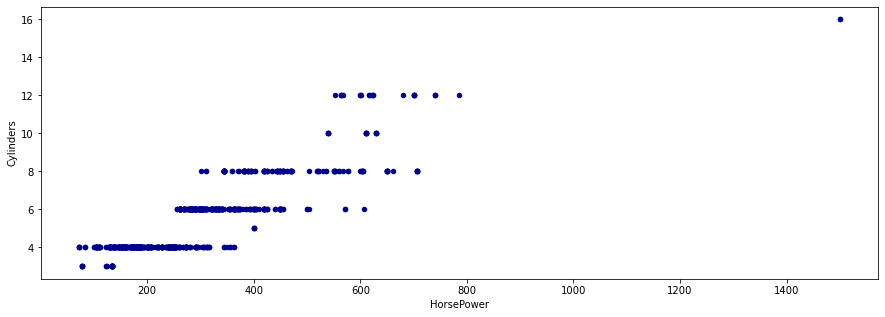

In [18]:
epa.plot.scatter(x='HorsePower',
                      y='Cylinders',
                      c='DarkBlue',
                figsize=(15,5))

<AxesSubplot:xlabel='HorsePower', ylabel='Weight'>

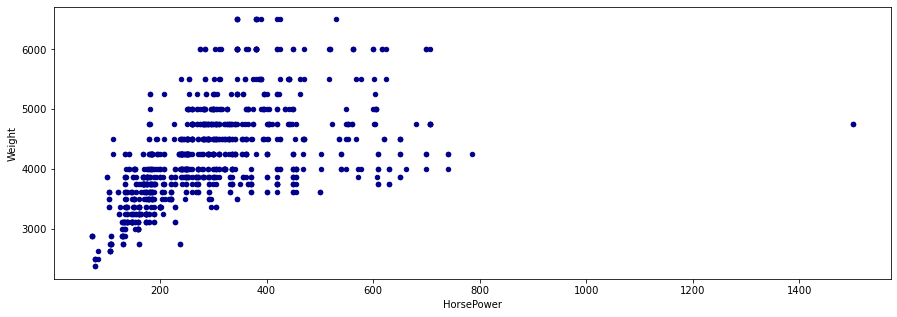

In [19]:
epa.plot.scatter(x='HorsePower',
                      y='Weight',
                      c='DarkBlue',
                figsize=(15,5))

<AxesSubplot:xlabel='HorsePower', ylabel='FuelEcon'>

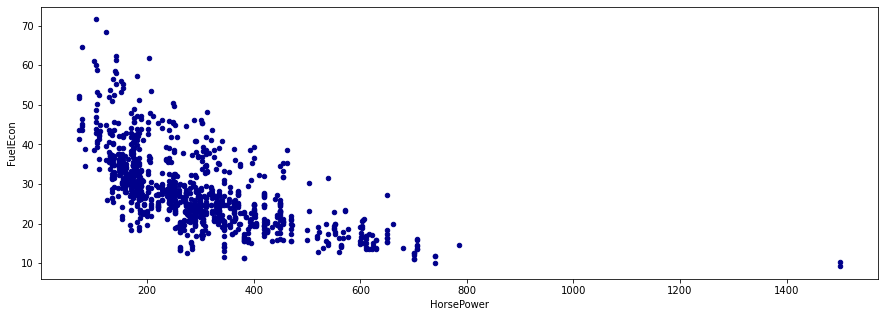

In [20]:
epa.plot.scatter(x='HorsePower',
                      y='FuelEcon',
                      c='DarkBlue',
                figsize=(15,5))

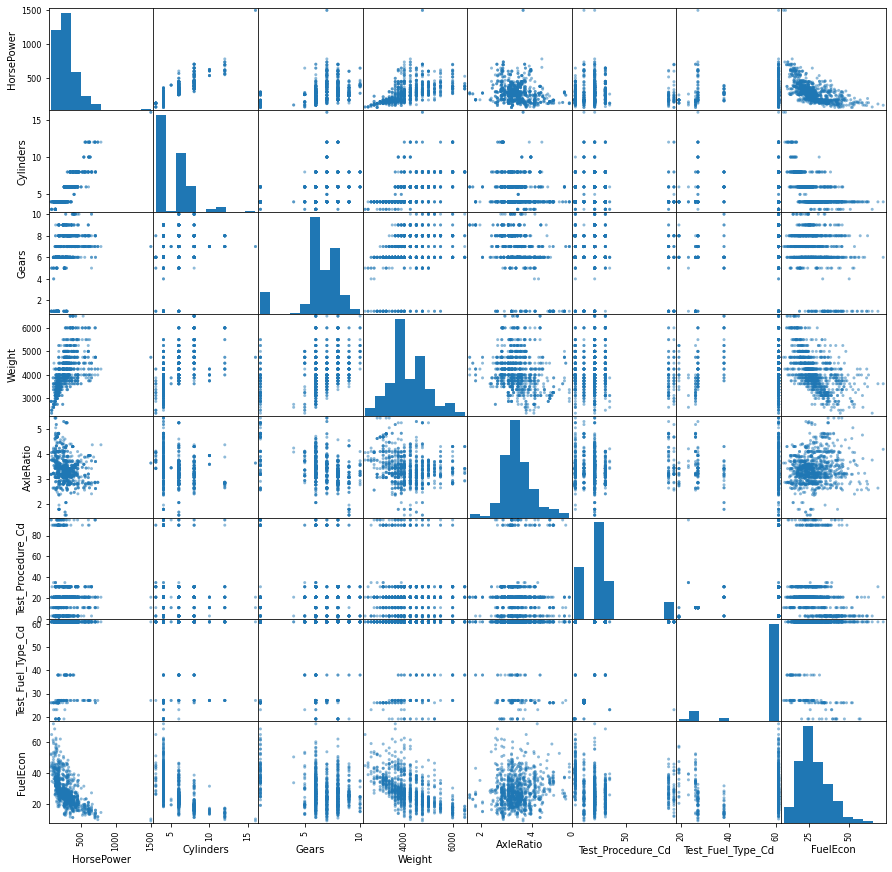

In [21]:
plot = pd.plotting.scatter_matrix(epa,
                figsize=(15,15))


In [22]:
epa.dtypes

HorsePower                         int64
Cylinders                          int64
Tested_Transmission_Type_Code     object
Gears                              int64
Drive_System_Code                 object
Weight                             int64
AxleRatio                        float64
Test_Procedure_Cd                  int64
Test_Fuel_Type_Cd                  int64
FuelEcon                         float64
dtype: object

In [23]:
epa['Tested_Transmission_Type_Code']= epa['Tested_Transmission_Type_Code'].astype('category')
    
epa['Drive_System_Code']= epa['Drive_System_Code'].astype('category')

In [24]:
epa = epa.sample(frac=1)
x_trn, y_trn, nas = proc_df(epa, 'FuelEcon')

In [25]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = int(len(x_trn)*.25)
print(n_valid)

n_trn = len(epa)-n_valid
print(n_trn)

x_train, x_valid = split_vals(x_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

raw_train, raw_valid = split_vals(epa, n_trn)


258
776


In [26]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    print("RMSE Train,           RMSE Prediction,    R^2 Train,         R^2 Prediction")
    res = [rmse(m.predict(x_train), y_train), 
            rmse(m.predict(x_valid), y_valid),
            m.score(x_train, y_train), 
            m.score(x_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [27]:
m = RandomForestRegressor()
m.fit(x_train, y_train)
print_score(m)

RMSE Train,           RMSE Prediction,    R^2 Train,         R^2 Prediction
[1.3451942531259993, 3.0018369361266246, 0.9805062421726505, 0.8890794303376761]


In [28]:
type(m)

sklearn.ensemble._forest.RandomForestRegressor

In [29]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=1, max_features=0.75,min_samples_split=2,oob_score=True)
m.fit(x_train, y_train)
print_score(m)

RMSE Train,           RMSE Prediction,    R^2 Train,         R^2 Prediction
[1.3287089900423432, 2.9373511108704515, 0.9809811038587684, 0.8937938608123359, 0.8618235524071379]


In [30]:
m = RandomForestRegressor()
m.fit(x_train, y_train)
print_score(m)

RMSE Train,           RMSE Prediction,    R^2 Train,         R^2 Prediction
[1.310278112879034, 3.061457801879266, 0.9815050767667671, 0.8846295856287494]


In [31]:
epa

HorsePower  Cylinders Tested_Transmission_Type_Code  Gears  \
950         292          4                           AMS      7   
317         272          4                            SA      8   
565         290          6                            SA      6   
3           616         12                            SA      8   
894         186          4                           AMS      7   
..          ...        ...                           ...    ...   
333         194          4                             A      6   
369         345          8                             A      6   
794         330          6                           AMS      8   
681         155          4                            SA      7   
285         260          4                            SA      9   

    Drive_System_Code  Weight  AxleRatio  Test_Procedure_Cd  \
950                 F    3875       3.30                  3   
317                 R    3625       3.27                  3   
565                 A    4500       3.04                 21   
3                   F    6000       2.85                 11   
894                 F    3750       3.13                 90   
..                ...     ...        ...                ...   
333                 R    4500       4.10                 31   
369                 R    6000       3.42                  3   
794                 R    4750       3.36                 21   
681                 4    3875       2.65                  3   
285                 F    3750       2.89                 31   

     Test_Fuel_Type_Cd  FuelEcon  
950                 61      40.8  
317                 61      44.6  
565                 61      22.3  
3                   27      13.6  
894                 61      30.7  
..                 ...       ...  
333                 61      23.0  
369                 61      30.3  
794                 61      26.4  
681                 61      42.3  
285                 61      29.7  

[1034 rows x 10 columns]

In [32]:
holdme = epa

trans = pd.get_dummies(holdme['Tested_Transmission_Type_Code'], prefix='TransType')
holdme = pd.concat([holdme, trans], axis=1)
holdme = holdme.drop([ 'Tested_Transmission_Type_Code'], axis=1)

trans = pd.get_dummies(holdme['Drive_System_Code'], prefix='DrvCode')
holdme = pd.concat([holdme, trans], axis=1)
holdme = holdme.drop([ 'Drive_System_Code'], axis=1)

epa = holdme
epa.shape

(1034, 20)

## Sagemaker 

In [33]:

XX_train, XX_test, yy_train, yy_test = train_test_split(epa, epa.iloc[0:,7:8], test_size=0.20)

XX_train = XX_train.drop(columns=['FuelEcon'])
XX_test = XX_test.drop(columns=['FuelEcon'])

#train = pd.concat((pd.DataFrame(epa.iloc[:,9:10]),pd.DataFrame(epa.iloc[:,0:9])),axis = 1)

XX_Train = pd.concat((pd.DataFrame(yy_train),pd.DataFrame(XX_train)),axis = 1)

XX_valid = pd.concat((pd.DataFrame(yy_test),pd.DataFrame(XX_test)),axis = 1)


In [34]:
XX_Train

FuelEcon  HorsePower  Cylinders  Gears  Weight  AxleRatio  \
529      24.8         340          6      8    4500       3.23   
47       26.5         300          6      8    4500       3.23   
513      47.3         180          4      8    4500       3.23   
469      33.2         201          4      7    3375       3.61   
566      22.1         290          6      6    4500       3.04   
..        ...         ...        ...    ...     ...        ...   
996      28.3         292          4      6    3625       3.09   
774      27.5         370          6      7    4000       3.44   
764      22.7         450          6      7    3625       3.59   
382      25.5         262          4      9    4750       3.49   
724      18.0         261          6      5    5000       3.36   

     Test_Procedure_Cd  Test_Fuel_Type_Cd  TransType_A  TransType_AM  \
529                 21                 61            0             0   
47                  31                 61            0             0   
513                  3                 19            0             0   
469                 21                 61            0             1   
566                 21                 61            0             0   
..                 ...                ...          ...           ...   
996                 90                 61            0             0   
774                 21                 61            0             0   
764                 21                 61            0             0   
382                 31                 61            1             0   
724                 31                 61            1             0   

     TransType_AMS  TransType_CVT  TransType_M  TransType_SA  TransType_SCV  \
529              0              0            0             1              0   
47               0              0            0             1              0   
513              0              0            0             1              0   
469              0              0            0             0              0   
566              0              0            0             1              0   
..             ...            ...          ...           ...            ...   
996              0              0            1             0              0   
774              1              0            0             0              0   
764              0              0            1             0              0   
382              0              0            0             0              0   
724              0              0            0             0              0   

     DrvCode_4  DrvCode_A  DrvCode_F  DrvCode_P  DrvCode_R  
529          1          0          0          0          0  
47           0          0          0          0          1  
513          1          0          0          0          0  
469          0          0          1          0          0  
566          0          0          1          0          0  
..         ...        ...        ...        ...        ...  
996          0          1          0          0          0  
774          0          0          0          0          1  
764          0          0          0          0          1  
382          0          0          1          0          0  
724          0          0          0          0          1  

[827 rows x 20 columns]

In [35]:
from io import StringIO 

# Reformat csv file

bucket = 'data-shep'
csv_buffer = StringIO()

XX_Train.to_csv(csv_buffer,header=False, index=False)
s3_resource = boto3.resource('s3')

s3_resource.Object(bucket, 'epa-Orcha_train.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'BZYKM04BJA37KSCZ',
  'HostId': 'ajNqhiDhmKNeWMHdoPB3p3iIRxog+U16Rbm+hyIcMyF7HguaGcakZ+9qv5Xxk4WH8ftL9hu1jVw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ajNqhiDhmKNeWMHdoPB3p3iIRxog+U16Rbm+hyIcMyF7HguaGcakZ+9qv5Xxk4WH8ftL9hu1jVw=',
   'x-amz-request-id': 'BZYKM04BJA37KSCZ',
   'date': 'Wed, 23 Jun 2021 15:24:04 GMT',
   'x-amz-version-id': 'S6EWQhKeCcPdCFnI2.YX7dmR501iCcZQ',
   'etag': '"524b2f1180ebb69a7e40a366719f242b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"524b2f1180ebb69a7e40a366719f242b"',
 'VersionId': 'S6EWQhKeCcPdCFnI2.YX7dmR501iCcZQ'}

In [36]:
from io import StringIO 

# Reformat csv file

bucket = 'data-shep'
csv_buffer = StringIO()

XX_valid.to_csv(csv_buffer,header=False, index=False)
s3_resource = boto3.resource('s3')

s3_resource.Object(bucket, 'epa-Orcha_valid.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'BZYGBVWNYYCNZBEJ',
  'HostId': '2bMIActdCz+xoKYNjgGZQSfVsK6VWCtxfjvJp0LaJmJKjLA0iixeRvzTVyvPrT0Bygbi1F70vYI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '2bMIActdCz+xoKYNjgGZQSfVsK6VWCtxfjvJp0LaJmJKjLA0iixeRvzTVyvPrT0Bygbi1F70vYI=',
   'x-amz-request-id': 'BZYGBVWNYYCNZBEJ',
   'date': 'Wed, 23 Jun 2021 15:24:04 GMT',
   'x-amz-version-id': 'HIS34xIddLN85ycerwwBM8dYW2Oo5xIj',
   'etag': '"1bab22b23f20ea817bb5b6e60e6efa4b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"1bab22b23f20ea817bb5b6e60e6efa4b"',
 'VersionId': 'HIS34xIddLN85ycerwwBM8dYW2Oo5xIj'}

In [38]:
# Define IAM role

import re
from sagemaker import get_execution_role

role = "arn:aws:iam::759916367757:role/service-role/AmazonSageMaker-ExecutionRole-20210219T114537"

In [39]:
#from sagemaker.amazon.amazon_estimator import get_image_uri
#container = get_image_uri(boto3.Session().region_name, 'xgboost')

from sagemaker.amazon.amazon_estimator import image_uris

container = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name,'latest')



In [40]:
from sagemaker.inputs import TrainingInput
s3_input_train = TrainingInput(s3_data='https://data-shep.s3.amazonaws.com/epa-Orcha_train.csv', content_type='csv')
s3_input_validation = TrainingInput(s3_data='https://data-shep.s3.amazonaws.com/epa-Orcha_valid.csv',content_type='csv')

data_channels = {'train': s3_input_train, 'validation': s3_input_validation}

In [41]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge',
                                    output_path='s3://data-shep/output',
                                    sagemaker_session=sess)
xgb.set_hyperparameters(feature_dim=19,
                        predictor_type='regressor',
                        num_round=100)

#xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2021-06-23 15:24:30 Starting - Starting the training job...
2021-06-23 15:24:51 Starting - Launching requested ML instancesProfilerReport-1624461870: InProgress
.........
2021-06-23 15:26:33 Starting - Preparing the instances for training......
2021-06-23 15:27:33 Downloading - Downloading input data...
2021-06-23 15:28:07 Training - Training image download completed. Training in progress.
2021-06-23 15:28:07 Uploading - Uploading generated training model.Arguments: train
[2021-06-23:15:28:02:INFO] Running standalone xgboost training.
[2021-06-23:15:28:02:INFO] File size need to be processed in the node: 0.05mb. Available memory size in the node: 7890.75mb
[2021-06-23:15:28:02:INFO] Determined delimiter of CSV input is ','
[15:28:02] S3DistributionType set as FullyReplicated
[15:28:02] 827x19 matrix with 15713 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-06-23:15:28:02:INFO] Determined delimiter of CSV input is ','
[15:28:02] S3DistributionTy


2021-06-23 15:28:33 Completed - Training job completed
Training seconds: 51
Billable seconds: 51


In [42]:
sagemaker.TrainingJobAnalytics(xgb._current_job_name,
                               metric_names=[],
                              ).dataframe()

timestamp      metric_name     value
0        0.0       train:rmse  0.394434
1        0.0  validation:rmse  2.451660

In [43]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge',
                          model_name="EPA-2018-01")


Using already existing model: EPA-2018-01


-------------!

In [44]:
xgb_predictor.endpoint_name

'xgboost-2021-06-23-15-36-22-310'

In [45]:
#from sagemaker.predictor import csv_serializer, RealTimePredictor
#from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON

#xgb_predictor.content_type = 'text/csv'
#xgb_predictor.serializer = csv_serializer
from sagemaker.serializers import CSVSerializer

from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name=xgb_predictor.endpoint_name, sagemaker_session=sess, serializer=CSVSerializer())

In [46]:
#HorsePower,Cylinders,Tested_Transmission_Type_Code,Gears,Drive_System_Code,Weight,AxleRatio,Test_Procedure_Cd,Test_Fuel_Type_Cd


payload = "1500,16,8,4050,3.15,21,61,0,0,0,0,0,1,0,0,0,0,0,1"
predictor = Predictor(endpoint_name=xgb_predictor.endpoint_name,
                              sagemaker_session=sess, 
                              serializer=CSVSerializer(),
                              ContentType='text/csv')
print(predictor.predict(payload))


b'12.030159950256348'


In [ ]:
#sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)